In [84]:
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [85]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1-a2dbUDDHsmkWOXoDYvgvCa8WBkEMzbr'})

In [88]:
ls

adc.json  automotive_rev_json.gz  sample_data/


In [0]:
download.GetContentFile('automotive_rev_json.gz')

In [0]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [92]:
df = getDF('automotive_rev_json.gz')
df.shape

(20473, 9)

In [93]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4.0,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5.0,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5.0,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [0]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


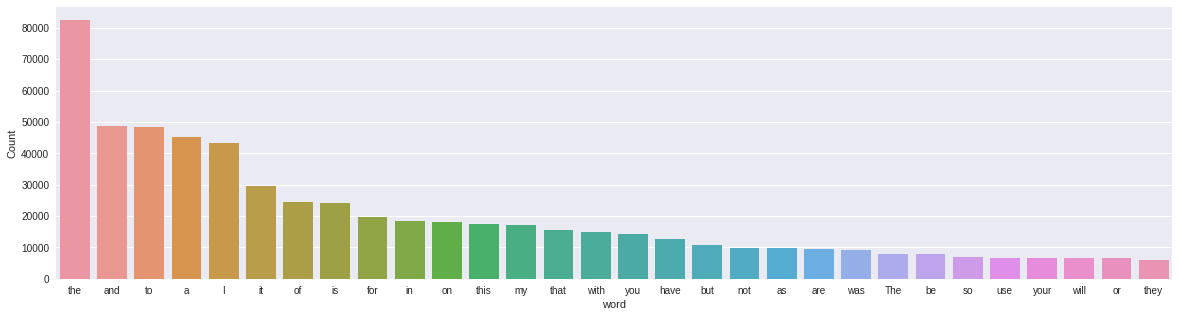

In [95]:
freq_words(df['reviewText'])

In [0]:
# replace "n't" with " not"
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


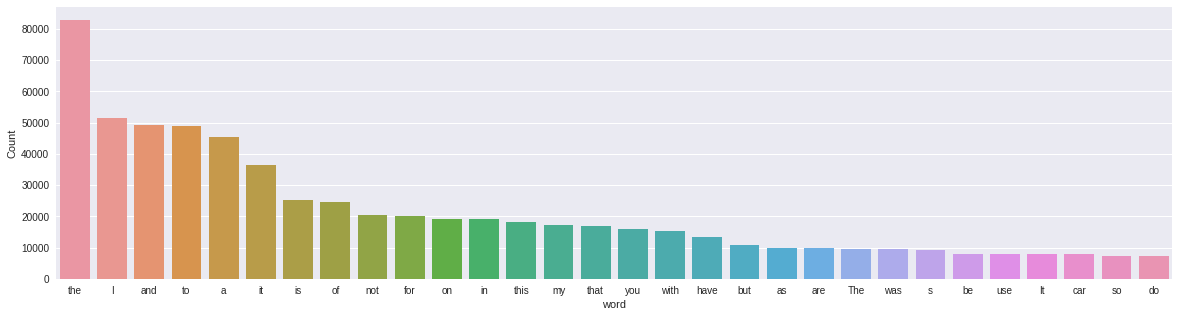

In [97]:
freq_words(df['reviewText'])

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [0]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [0]:
# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


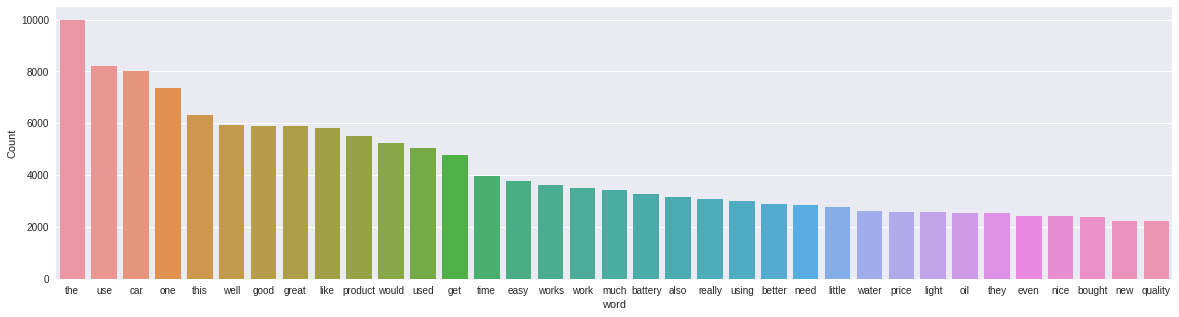

In [101]:
freq_words(reviews, 35)

In [0]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [0]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [0]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

In [105]:
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


29

In [0]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

In [107]:
print(reviews_2[1])
len(reviews_2[1])

['long', 'cable', 'fine', 'truck', 'quality', 'little', 'shabby', 'side', 'money', 'dollar', 'jumper', 'cable', 'chinese', 'shop', 'harbor', 'freight', 'buck']


17

In [108]:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'bucks',
 'cables',
 'expecting',
 'for',
 'knock',
 'like',
 'see',
 'seem',
 'seems',
 'snap',
 'these',
 'work',
 'would'}

In [0]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


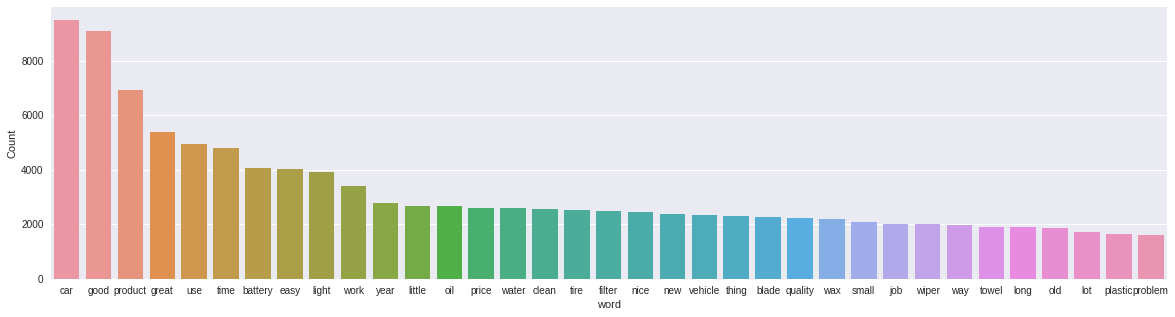

In [111]:
freq_words(df['reviews'], 35)

In [0]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [0]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [0]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [0]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [119]:
lda_model.print_topics()

[(0,
  '0.030*"car" + 0.026*"oil" + 0.020*"filter" + 0.018*"engine" + 0.016*"device" + 0.013*"code" + 0.012*"vehicle" + 0.011*"app" + 0.011*"change" + 0.008*"bosch"'),
 (1,
  '0.017*"easy" + 0.014*"install" + 0.014*"door" + 0.013*"tape" + 0.013*"jeep" + 0.011*"front" + 0.011*"mat" + 0.010*"side" + 0.010*"headlight" + 0.008*"fit"'),
 (2,
  '0.054*"blade" + 0.045*"wiper" + 0.019*"windshield" + 0.014*"rain" + 0.012*"snow" + 0.012*"good" + 0.011*"year" + 0.011*"old" + 0.011*"car" + 0.009*"time"'),
 (3,
  '0.044*"car" + 0.024*"towel" + 0.020*"product" + 0.018*"clean" + 0.017*"good" + 0.016*"wax" + 0.014*"water" + 0.013*"use" + 0.011*"time" + 0.011*"wash"'),
 (4,
  '0.051*"light" + 0.039*"battery" + 0.021*"bulb" + 0.019*"power" + 0.018*"car" + 0.014*"bright" + 0.013*"unit" + 0.011*"charger" + 0.010*"phone" + 0.010*"charge"'),
 (5,
  '0.022*"tire" + 0.015*"hose" + 0.013*"use" + 0.012*"good" + 0.010*"easy" + 0.010*"pressure" + 0.009*"small" + 0.009*"trailer" + 0.008*"nice" + 0.008*"water"'),
 

In [120]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      21.143177        1       1 -0.023091  0.141023
5      18.369776        1       2  0.096649  0.048498
6      15.248682        1       3 -0.107528  0.202428
4      14.674014        1       4 -0.112982 -0.163065
0      11.917589        1       5 -0.154058 -0.131336
1       9.814881        1       6  0.285191 -0.062285
2       8.831884        1       7  0.015820 -0.035264, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
319   Default  6340.000000      product  6340.000000  30.0000  30.0000
147   Default  4672.000000        light  4672.000000  29.0000  29.0000
952   Default  2615.000000        blade  2615.000000  28.0000  28.0000
39    Default  3131.000000      battery  3131.000000  27.0000  27.0000
928   Default  2179.000000        wiper  2179.000000  26.0000  26.0000
2     Default  9494.000000          car  9494.000000  25.0000  25.0000
529   Default  2742.000000        towel  2742.000000  24.0000  24.0000
17    Default  2242.000000        price  2242.000000  23.0000  23.0000
336   Default  2251.000000         tire  2251.000000  22.0000  22.0000
168   Default  1721.000000          oil  1721.000000  21.0000  21.0000
2584  Default  1670.000000         bulb  1670.000000  20.0000  20.0000
1316  Default  1703.000000      leather  1703.000000  19.0000  19.0000
525   Default  1810.000000          wax  1810.000000  18.0000  18.0000
32    Default  1980.000000      quality  1980.000000  17.0000  17.0000
62    Default  1610.000000        power  1610.000000  16.0000  16.0000
963   Default  1270.000000       filter  1270.000000  15.0000  15.0000
95    Default  2326.000000        clean  2326.000000  14.0000  14.0000
117   Default  1147.000000       engine  1147.000000  13.0000  13.0000
725   Default  1511.000000         hose  1511.000000  12.0000  12.0000
927   Default   938.000000   windshield   938.000000  11.0000  11.0000
1272  Default  1133.000000       bright  1133.000000  10.0000  10.0000
524   Default  2705.000000        water  2705.000000   9.0000   9.0000
757   Default  1380.000000       device  1380.000000   8.0000   8.0000
550   Default  1238.000000         wash  1238.000000   7.0000   7.0000
730   Default  1228.000000         unit  1228.000000   6.0000   6.0000
643   Default  1153.000000        paint  1153.000000   5.0000   5.0000
1187  Default   907.000000      charger   907.000000   4.0000   4.0000
723   Default   814.000000         code   814.000000   3.0000   3.0000
475   Default   955.000000      install   955.000000   2.0000   2.0000
962   Default   730.000000         door   730.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1185   Topic7   424.670807       winter   505.461731   2.2526  -4.7314
1012   Topic7   127.780693       vision   150.216125   2.2650  -5.9324
936    Topic7   259.161133      weather   392.846741   2.0108  -5.2253
534    Topic7   260.354858     original   446.545654   1.8873  -5.2207
340    Topic7   222.457581         cold   362.730499   1.9379  -5.3780
624    Topic7   152.985733       summer   225.406784   2.0392  -5.7524
820    Topic7   340.229797       window   780.110474   1.5970  -4.9531
261    Topic7   533.777405          old  1689.711670   1.2745  -4.5028
924    Topic7   311.730774        glass   722.981567   1.5856  -5.0406
1235   Topic7   239.638931  replacement   477.028687   1.7384  -5.3036
382    Topic7   328.168640        month   885.292664   1.4344  -4.9892
35     Topic7   438.155579         side  1477.705811   1.2111  -4.7002
538    Topic7   338.859558        clear   967.822327   1.3773  -4.9571
274    Topic7   545.789856         year  2317.310059   0.9809  -4.4805
141    Topic7   380.857422         last  1383.743652   1.1367  -4.8403
15     Topic7   435.130188          new  2132.450439   0.8374  

In [0]:
# Print the Keyword in the 10 topics
lda_model.print_topics()